# NLP from scratch: classification names with a character-level RNN

We will be building and training a basic character-level RNN to classfiy words. This tutorial show how to do preprocwss data for NLP modeling "from scratch", in particular not using many of the convenience functions of torchtext, so you can see how preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters - outputing a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be output, i.e. which class the word belong to.

Specially, we'll train on a few thousand surnames from 18 language of origin, and predict which language a name is from based on the spelling:

**Recommend Reading:**

* [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) show a bunch of real life example
* [Unstanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specially but also infromative about RNNs in general

## Preparing the Data

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to be current directory.

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly remanized.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

# print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per languae
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().split('\n')
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(all_categories, n_categories)

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish'] 18


Now we have `category_lines`, a dictionary mapping each category(language) to a list of lines. We also kept track of `all_categories` and `n_category` for later reference.

In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"n = <0 1 0 0 0 ...>"`

To make a word we join a bunch of those into a 2D matrix `line_length * 1 * n_letters`.

The extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [3]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'"

In [4]:
import torch

# Find letter index from all_letters
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstratioin, turn a letter into a <1 * n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length * 1 * n_letters>,
# or an array of one-hot letter vectors.
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        return tensor

In [5]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradient which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/Z2xbySO.png)

In [29]:
import torch.nn as nn

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input(in our case, the Tensor of the current letter) and a prevoius hidden state(which we initialize as zero at first). We'll get back the output and a next hidden state.

In [13]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficency we don't want to be creating a new Tensor for every step, we will use `lineToTensor` instead of `letterToTensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [15]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7640, -2.9829, -2.8738, -2.9306, -2.9125, -2.7998, -2.9273, -2.8193,
         -2.7767, -2.9025, -2.9797, -2.9537, -2.8140, -3.0204, -2.8634, -2.8943,
         -2.9136, -2.9452]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a `<1 * n_categories>` Tensor, where every item is the likelihood of that category(higher is more likely).

**RNN model visualization**

In [63]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/rnn_classification')

In [64]:
writer.add_graph(rnn, (input[0], hidden))

## Training

### Preparing for Training

Before going intot training we should make a few helper functions. The first is to intrpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [22]:
all_categories

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 0)


In [37]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Pecora
category = Spanish / line = Escamilla
category = Italian / line = Gismondi
category = English / line = Arthur
category = Greek / line = Close
category = Vietnamese / line = Pham
category = Greek / line = Egonidis
category = Arabic / line = Tannous
category = Japanese / line = Hiraki
category = Korean / line = Jang


### Training the Network

For the loss function `nn.NLLLoss` is appropriate, since the last year of the RNN is `nn.LogSoftmax`.

In [26]:
criterion = nn.NLLLoss()

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each line in and 
  * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [38]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that wit a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. 

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 100



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    if line_tensor is None: continue

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        writer.add_scalar('training loss', current_loss/plot_every, iter)
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 0.8293 Rompaeij / Dutch ✓
10000 10% (0m 15s) 0.3060 Ko / Korean ✓
15000 15% (0m 22s) 1.9826 Parris / Czech ✗ (French)
20000 20% (0m 30s) 1.0558 Wiater / Polish ✓
25000 25% (0m 38s) 1.6719 Accorso / Portuguese ✗ (Italian)
30000 30% (0m 46s) 2.6761 Muruyama / Greek ✗ (Japanese)
35000 35% (0m 53s) 4.1879 Peerenboom / Greek ✗ (Dutch)
40000 40% (1m 0s) 1.9852 Romao / Spanish ✗ (Portuguese)
45000 45% (1m 8s) 1.7667 Horiuchi / Japanese ✓
50000 50% (1m 15s) 3.5040 Armistead / Italian ✗ (French)
55000 55% (1m 23s) 2.4347 Ponec / Spanish ✗ (Czech)
60000 60% (1m 31s) 3.2259 Kinsley / Czech ✗ (English)
65000 65% (1m 38s) 3.6178 Chalupka / Scottish ✗ (Czech)
70000 70% (1m 46s) 1.6591 Desantigo / Portuguese ✓


### Plotting the Results

Plotting the historical loss from `all_losses` show the network learning:

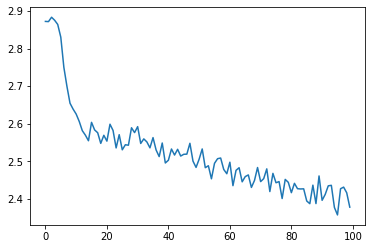

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating of every actual language(rows) which language the network guesses(columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

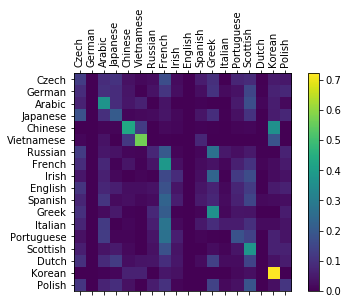

In [52]:
# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    if line_tensor is None: continue
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Running on User Input

In [53]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.71) French
(-1.82) Portuguese
(-1.98) Irish

> Jackson
(-1.83) Czech
(-1.88) Polish
(-2.56) Dutch

> Satoshi
(-1.89) Czech
(-2.20) Polish
(-2.32) Japanese


The final version of the scripts split into the above code into a few files:

* `data.py` load files
* `model.py` define the RNN
* `train.py` runs training
* `predict.py` run `predict()` with command line arguments
* `server.py` save prediction as JSON API with bottle.py

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions.